<span style="color:red;font-size:2em;font-weight:bold"> PARTIE 3 - Optimisation du modèle</span>

In [1]:
# Roots
import numpy as np
import pandas as pd
# import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json,pickle

# Stats
# from scipy.stats import skew, kurtosis, zscore, chi2_contingency, f_oneway, chi2
# from statsmodels.stats.outliers_influence import variance_inflation_factor

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
    StratifiedShuffleSplit,
    cross_val_predict,
    # KFold,
    StratifiedKFold,
    RandomizedSearchCV,
)
# Metrics
from sklearn.metrics import (
    accuracy_score, auc, classification_report, confusion_matrix, f1_score, fbeta_score, precision_recall_curve, 
    precision_score, recall_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay,make_scorer
)
# mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

# Feature importance
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, RobustScaler,PowerTransformer
from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

#Modèles
from sklearn.dummy import DummyClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool

#SHAP
import shap


In [2]:
# Sert à éviter les Warnings avec les transformations sur des vues en transformant 
# ces warning en erreur obligeant ainsi à ne travailler que sur des copies ou les originaux.

pd.set_option('mode.chained_assignment','raise')

In [3]:
# Module pour recharger un module sans redemarrer le kernel
# import importlib
%load_ext autoreload
%autoreload 2

In [4]:
# Ajoute le dossier utils au sys.path. Remarque ne pas oublier le __init__.py dans le dossier utils
import sys
utils_path = Path.cwd().parent/"utils"
sys.path.append(str(utils_path))
# Fonctions personnelles
from filtering_counters import cleaning_counter, cleaning_results, removedAndAdded_col # Suivi des filtrage des features et observations
from plotting import create_fig, make_figure, graphs, graph_hyperParamEffect, graph_importance # Fonctions de plotting
from correlation import graphs_corr, CorrCouples_VIF, chi2_test, anova_test # Fonctions de correlation
from misc import features_types, data_props, top_score, iqr_outliers,zmad_outliers, model_attr# Divers fonctions
from ml_modeling import cat_modeling_cv, gridsearchcv, Xy_tf, preproc, cat_modeling_cv_predict, Xy_folds # Fonctions pour la modélisation

In [5]:
# Paramètres globaux
save_all = True
random_state = 42
cv= 5
test_size = 0.2
name_model = "best_model"
load_model = True

# Sauvegardes
save_results = False # des plots
save_model = False # le meilleur modele
save_hyperparams = False # hyperparamètres utilisés
save_pool = False # pools utilisées
save_metrics_thresh = False # les métriques et le seuil de validation optimisé
if save_all:
    save_results = True # des plots
    save_model = True # le meilleur modele
    save_hyperparams = True # hyperparamètres utilisés
    save_pool = True # pools utilisées
    save_metrics_thresh = True # les métriques et le seuil de validation optimisé
    
#Paths
#
save_path_plots = Path.cwd().parent.joinpath('datas/results/plots')
Path.mkdir(save_path_plots,exist_ok = True)
#
save_path_model = Path.cwd().parent.joinpath('datas/results/model')
Path.mkdir(save_path_model,exist_ok = True)
#
save_path_threshold_opt = Path.cwd().parent.joinpath('datas/results/threshold_opt')
Path.mkdir(save_path_threshold_opt,exist_ok = True)
#
save_path_hyperparams = Path.cwd().parent.joinpath('datas/results/hyperparam')
Path.mkdir(save_path_hyperparams,exist_ok = True)
#
save_path_metrics = Path.cwd().parent.joinpath('datas/results/metrics')
Path.mkdir(save_path_metrics,exist_ok = True)
#
save_path_pool = Path.cwd().parent.joinpath('datas/results/pool')
Path.mkdir(save_path_pool,exist_ok = True)


In [6]:
# Importation des documents
Xy = pd.read_csv('../datas/results/Xy.csv')
Xy_lite = pd.read_csv('../datas/results/Xy_lite.csv')

<span style='color:purple;font-weight:bold'> X et y </span>

In [7]:
# Définition des prédicteurs X et de la cible y
X = Xy.drop(columns=['a_quitte_l_entreprise'])
y = Xy['a_quitte_l_entreprise']

<span style='color:purple;font-weight:bold'> Features numériques et catégorielles </span>

In [8]:
# Identification des features numériques et catégorielles
numeric_list, cat_list = features_types(X)

<span style='color:purple;font-weight:bold'> Séparation Train/test avec stratification </span>

In [9]:
# Train/Tests

X_train,X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size = test_size,
    random_state = random_state,
    stratify = y #Stratifie la proportion de y pour un unique split
)

<span style='color:purple;font-weight:bold'> Modèle </span>

In [10]:
# Modèle
model = CatBoostClassifier(random_state=random_state,#defaut = None
                            logging_level='Silent', # Evite de printer 1 milliard de ligne de progression
                            auto_class_weights = 'Balanced', # Pondère en équilibrant les classes
                            loss_function = 'Logloss', #La cible est binaire
                            # thread_count = 2, # limite a 2 threads par job
                          )

<span style='color:purple;font-weight:bold'> Métriques </span>

In [11]:
scoring = {
        'balanced_accu':'balanced_accuracy',
        'prec':'precision',
        'recall':'recall',
    }

CatBoost étant extrêmement puissant, robuste et versatile, il permet entre autres de réduire fortement le préprocessing (gère les features catégorielles car les encode en interne, les données manquantes, les distributions et échelles...)

[https://www.geeksforgeeks.org/machine-learning/introduction-to-catboost] (retiré %5d/ de l'adresse une fois validée pour arrivé sur la bonne page)

on peut donc réduire la structure de la modélisation (ce qu'on n'a pas fait en p2 car on compilait avec les autres modèles)

<span style='color:blue;font-size:1.5em;font-weight:bold;background-color:yellow'> Optimisation des hyperparamètres </span>

<span style='color:purple;font-weight:bold'> Grille de distribution </span>

In [12]:
# Grille de distribution des hyperparamètres d'études
param_distrib = {
    'depth':np.arange(2,7), # Profondeur de l'arbre /  risque d'overfit si important
    'learning_rate':np.arange(0.03,0.301,0.01), # Influence la vitesse d'apprentissage / Très sensible / bas = stable mais couteux
    'l2_leaf_reg':np.arange(2,11), # Coeff pour le terme L2 de regul de la fonction de cout (ecart entre y_pred et y_test pdt train) 
    # Controle l'ajustement du modèle face aux données notamment du bruit)
    'iterations':np.arange(100,500,100), # Nb max d'arbres / 300---500 par pas de 100 / à combiner avec early_stopping
    # 'subsample': np.linspace(0.5,1.,6),# Taux d'echantillonnage du bagging ou bootstrap aggragating/
    #1=boosting sinon stochastic boosting / Ne fonctionne pas avec bootstrap Bayesian or bayesian bon sur petit dataset
    'random_strength':np.linspace(1,5,9), # Controle le caractere aléatoire des splits / 0 = pas de randomisation
    'bootstrap_type': ['Bayesian','Bernoulli','No'], # Baye = echant probabiliste (bonne regul), 
    # Bernou = chaque obs est incluse avec prob = 'subsample', MVS = bootstrap basée su variance (bon pour gd data), No = pas de bootstrap
    'early_stopping_rounds':np.arange(50,151,50), #Arrête le train si perf ne s'améliore pas sur set de validation pdt ce nb d'iteration
}

<span style='color:purple;font-weight:bold'> RandomizedSearchCV </span>

Pour étudier les hyperparam afin de sotir le meilleur modèle parmis ceux testé on va devoir réaliser des combinaisons de ces paramètres, modéliser et comaprer les performances.  
Dans notre cas, avec ces hyperparamètres respectivement avec 9,50,9,9,10,3 et 4 valeurs on aurait 4.374.000 combinaisons à réaliser multiplier en plus par le nombre de validation croisée soit 21.870.000 entrainements au total (en séquentiel) ==> IMPOSSIBLE. Solution? On utilise à la place de GridSearchCV, **RandomizedSearchCV**, on peut ainsi limiter le nombre de combinaisons et l'aléatoire se chargera de choisir les combinaisons dans le spectre donné.

In [13]:
# # Check-up des coeurs dispo, pc ayant crashé ==> on va limiter le parallele
# import multiprocessing
# n_cores = multiprocessing.cpu_count()
# n_cores

In [14]:
rdm_search = RandomizedSearchCV(
    estimator = model,
    param_distributions = param_distrib,
    scoring = scoring,# "recall",
    refit = "recall",
    n_iter  = 200, # Contrôle le nombre de combinaison max
    cv = cv,
    # n_jobs = 1, # pas de calcul parallèle
    random_state = random_state,
    return_train_score = True,
    # verbose = 1, # Affiche temp de calcul pour chaque fold avec param candidat + le score
)

In [15]:
rdm_search.fit(
    X_train,
    y_train,
    cat_features = cat_list
)

,estimator,<catboost.cor...x76598aca1400>
,param_distributions,"{'bootstrap_type': ['Bayesian', 'Bernoulli', ...], 'depth': array([2, 3, 4, 5, 6]), 'early_stopping_rounds': array([ 50, 100, 150]), 'iterations': array([100, 200, 300, 400]), ...}"
,n_iter,200
,scoring,"{'balanced_accu': 'balanced_accuracy', 'prec': 'precision', 'recall': 'recall'}"
,n_jobs,None
,refit,'recall'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


<span style='color:purple;font-weight:bold'> Inclusion du seuil optimisé vu dans la partie précédente </span>

In [16]:
threshold_opt = 0.269441

In [17]:
y_pred_proba = rdm_search.predict_proba(X_test)[:,1]
y_pred = (y_pred_proba >= threshold_opt).astype(int)

<span style='color:purple;font-weight:bold'> Meilleur modèle </span>

In [18]:
best_model = rdm_search.best_estimator_

best_params = rdm_search.best_params_
best_score = rdm_search.best_score_

In [19]:
print('=======================Meilleurs combinaison=======================')
print(best_params)
print('=======================Meilleurs scores=======================')
print(best_score)

=======================Meilleurs combinaison=======================
{'random_strength': np.float64(2.5), 'learning_rate': np.float64(0.1), 'l2_leaf_reg': np.int64(7), 'iterations': np.int64(200), 'early_stopping_rounds': np.int64(100), 'depth': np.int64(2), 'bootstrap_type': 'Bayesian'}
=======================Meilleurs scores=======================
0.7157894736842106


<span style='color:purple;font-weight:bold'> Résultats </span>

In [20]:
results = pd.DataFrame(rdm_search.cv_results_)

In [22]:
results.T

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
mean_fit_time,1.275149,0.523115,1.522613,0.929353,1.501344,0.612932,0.578298,1.378608,0.551749,0.594111,...,1.102936,0.906247,1.283236,1.617897,0.927106,1.132143,0.73177,0.541597,0.609409,0.692947
std_fit_time,0.216177,0.048266,0.025158,0.036823,0.065858,0.037088,0.019908,0.057602,0.056522,0.158313,...,0.009743,0.061262,0.011351,0.060659,0.038359,0.021736,0.033163,0.0121,0.052814,0.049822
mean_score_time,0.019321,0.009371,0.009655,0.009896,0.009599,0.009998,0.0097,0.009702,0.010575,0.010274,...,0.009572,0.009421,0.009576,0.009715,0.00947,0.009435,0.009421,0.009583,0.010075,0.009524
std_score_time,0.019156,0.000185,0.000234,0.000486,0.000239,0.000721,0.000667,0.000576,0.001692,0.001147,...,0.000305,0.000275,0.000123,0.000088,0.000228,0.000491,0.000309,0.000025,0.001234,0.000093
param_random_strength,5.0,3.5,1.5,4.0,3.5,5.0,1.0,1.5,3.0,4.0,...,4.0,3.0,1.0,1.0,5.0,4.5,1.0,3.0,4.0,3.0
param_learning_rate,0.29,0.25,0.18,0.23,0.16,0.22,0.19,0.3,0.25,0.3,...,0.26,0.21,0.21,0.24,0.19,0.16,0.15,0.03,0.08,0.23
param_l2_leaf_reg,8,8,3,4,4,9,7,7,3,6,...,2,5,6,8,2,2,7,9,10,5
param_iterations,200,100,300,200,300,100,100,400,100,100,...,400,200,400,300,300,400,100,100,100,100
param_early_stopping_rounds,100,100,150,100,100,100,50,100,50,50,...,100,150,100,50,100,150,150,50,100,150
param_depth,6,2,6,5,6,6,6,4,4,2,...,2,4,3,6,2,2,6,2,5,6


<span style='color:purple;font-weight:bold'> Réduction de l'overfitting </span>

In [29]:
# cols_restriction = results.columns[results.columns.str.contains("_train") | results.columns.str.contains("_test")]
cols_restriction_train = results.columns[results.columns.str.contains("mean_train")]
cols_restriction_test = results.columns[results.columns.str.contains("mean_test")]
display(results.loc[results['params'] == best_params,cols_restriction_train])
display(results.loc[results['params'] == best_params,cols_restriction_test])

,mean_train_balanced_accu,mean_train_prec,mean_train_recall
122,0.863272,0.547751,0.864474


,mean_test_balanced_accu,mean_test_prec,mean_test_recall
122,0.76917,0.443048,0.715789


Réduction de l'overfiting à la suite de l'optimisation

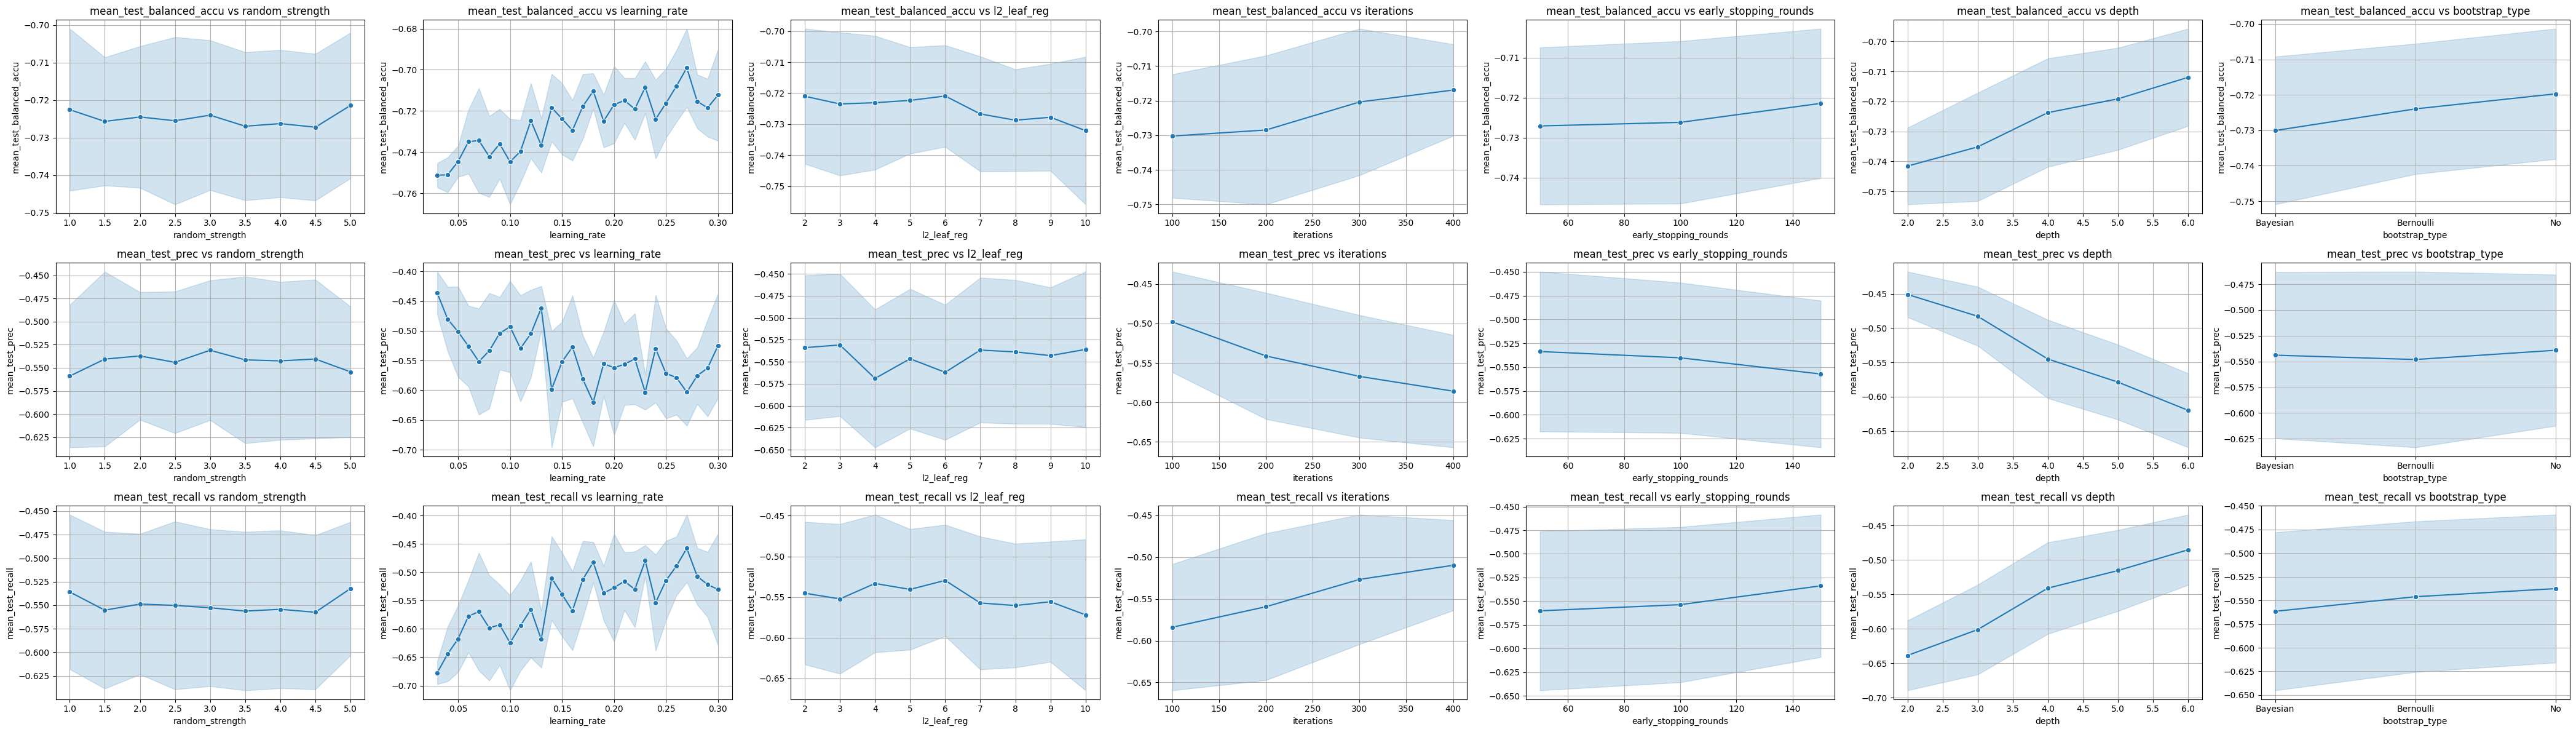

In [22]:
graph_hyperParamEffect(
    results=results, 
    params_prefix='param_', 
    metrics_prefixe='mean_test_',
    title_save = "hyperParamEffect",
    save = save_results
)

In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.55      0.69       247
           1       0.26      0.83      0.39        47

    accuracy                           0.59       294
   macro avg       0.60      0.69      0.54       294
weighted avg       0.83      0.59      0.64       294



In [24]:
y_pred_best_model_thresh05 = best_model.predict(X_test) # retourne la prédiction suivant seuil de 0.5 avec le meilleur modele

In [25]:
print(classification_report(y_test,y_pred_best_model_thresh05))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       247
           1       0.40      0.66      0.50        47

    accuracy                           0.79       294
   macro avg       0.66      0.74      0.68       294
weighted avg       0.84      0.79      0.81       294



<span style='color:blue;font-size:1.5em;font-weight:bold;background-color:yellow'> Feature importance </span>

Maintenant qu'on a fini d'évaluer les hyperparamètres et que nous avons notre meilleur modèle, on peut finir par l'analyse de l'importance des features en employant le modèle trouver et en regardant à nouveau sur **toutes les observations des features (X)**.

In [28]:
# graph_importance(best_model, 
#                  preproc=best_model.preproc, 
#                  numeric_list = numeric_list, 
#                  non_numeric_list = cat_list,
#                  mode="feature",
#                  title_save="CatBoostClassifier"
#                 )

feature_importance = best_model.get_feature_importance(type = "PredictionValuesChange")
df_feat_importance = pd.DataFrame({
    'Features':X.columns,
    'Feature importance': feature_importance
}).sort_values('Feature importance',ascending=False)

In [29]:
df_feat_importance

,Features,Feature importance
16,freq_chgt_poste,12.966476
4,poste,10.301867
20,satisfaction_globale_employee,10.294863
6,heure_supplementaires,9.952512
2,revenu_mensuel,8.526243
19,freq_chgt_responsable,6.525310
0,age,6.353483
8,nombre_participation_pee,5.656807
10,distance_domicile_travail,5.121929
17,revenu_mensuel_ajuste_par_nv_hierarchique,4.646676


In [30]:
permutation_importance = best_model.get_feature_importance(
    type = "PredictionValuesChange",
    data = Pool(X,y,cat_features=cat_list)
)
df_perm_importance = pd.DataFrame({
    'Features':X.columns,
    'Permutation importance': permutation_importance
}).sort_values('Permutation importance',ascending=False)

In [31]:
df_perm_importance

,Features,Permutation importance
16,freq_chgt_poste,13.539177
6,heure_supplementaires,11.033849
20,satisfaction_globale_employee,10.191483
4,poste,9.481975
2,revenu_mensuel,8.027182
0,age,6.724167
19,freq_chgt_responsable,6.669510
8,nombre_participation_pee,5.546695
10,distance_domicile_travail,4.948992
15,stagnation_promo,4.497407


Text(0, 0.5, 'Features')

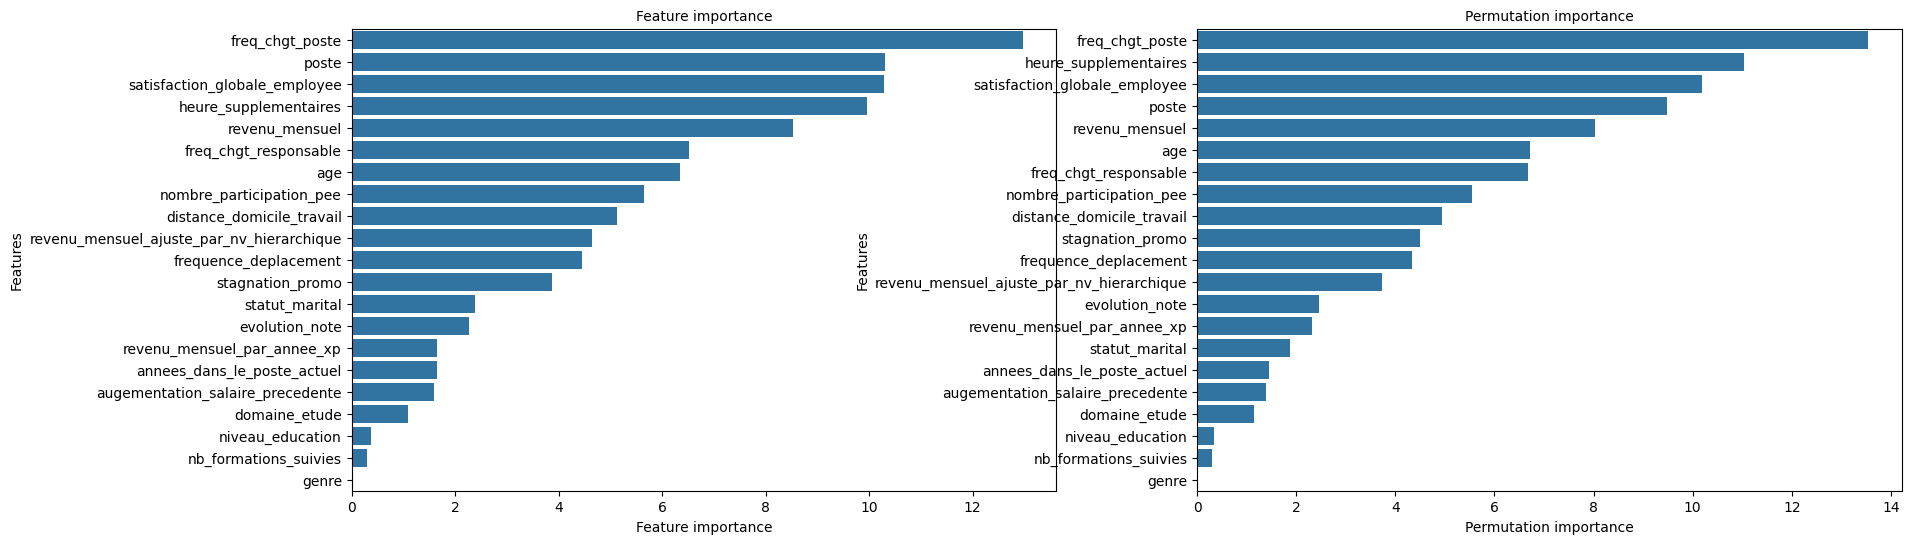

In [32]:
fig, axes  = plt.subplots(
    1,2,figsize=(20,6),clear=True
)

sns.barplot(
    x=df_feat_importance['Feature importance'],
    y=df_feat_importance['Features'],
    ax=axes[0]
)
sns.barplot(
    x=df_perm_importance['Permutation importance'],
    y=df_perm_importance['Features'],
    ax=axes[1]
)

axes[0].set_title(f"Feature importance", fontsize=10)
axes[0].set_xlabel("Feature importance")
axes[0].set_ylabel("Features")
axes[1].set_title(f"Permutation importance", fontsize=10)
axes[1].set_xlabel("Permutation importance")
axes[1].set_ylabel("Features")

In [73]:
# SHAP GLOBAL
tree_xp = shap.TreeExplainer(best_model)
shap_xp = tree_xp(X) #Explanation object / on revient sur X car on A notre modele le plus performant et on regarde les features maintenant

In [74]:
type(shap_xp)

shap._explanation.Explanation

<span style='color:purple;font-weight:bold'> Feature importance globale (feature/permutation importance et SHAP: beeswarm) </span>

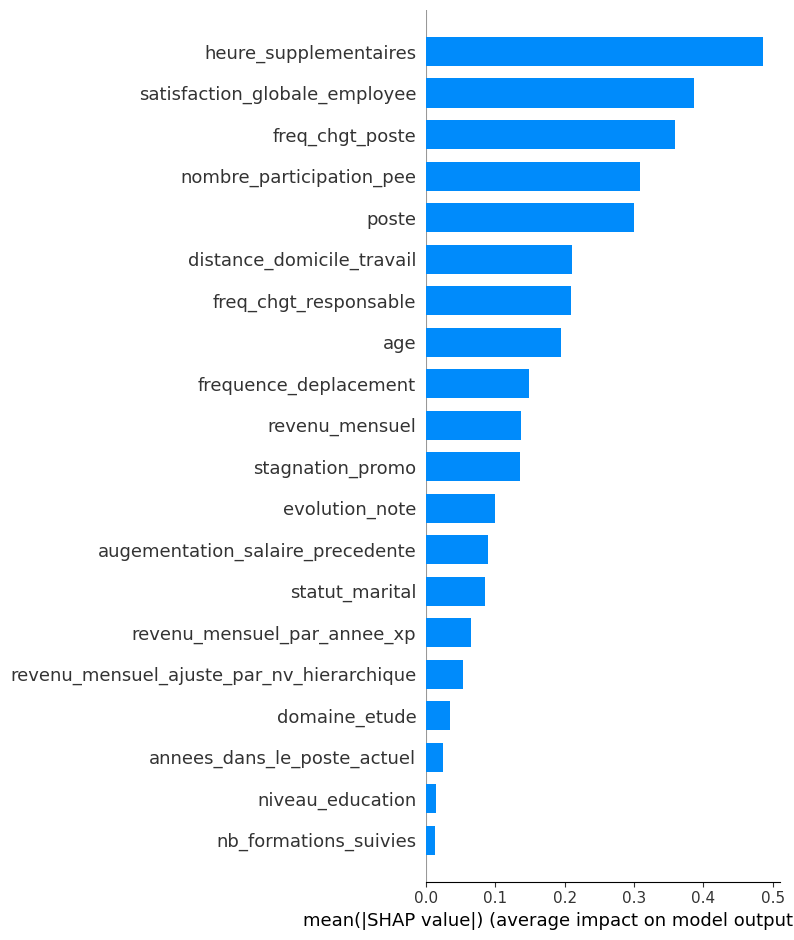

In [75]:
# Représentation dans le même style que feature et permutaiton importance mais utilise les shapley (précis, prend en compte interactions)
shap.summary_plot(shap_xp,X,plot_type="bar")

Il existe de multiples façons d'étudier l'influence des features chacune avec des qualités et des défauts:
- La feature importance mesure l'importance d'une feature en moyennant l'effet des splits de cette feature sur la prédiction. Elle a l'avantage d'être rapide à mettre en oeuvre cependant elle peut être biaisé en cas de splits elevé ou d'un nombre elevé de catégories.
- La permutation importance regarde la dégradation des performances lorsqu'on permute les valeurs d'une feature. Plus versatile et robuste, elle permet de detecter l'importance des features et leur combinaisons mais elle est beaucoup plus couteuse puisqu'elle nécéssite de recalculer les prédictions à chaque permutation.
- Le shap barplot utilise les shapley afin d'afficher la moyenne absolue des shapley pour chaque feature. Elle montre en sommes, la contribution de chaque feature à la prédiction ce qui permet de prendre en compte les interactions des features ce qui pemet d'avoir une vue d'ensemble fiable, robuste et complète de l'influence des features en contrepartie d'un temps de calcul plus elevé.

En comparant les trois méthodes (notre dataset étant assez limité, on peut se permettre cela), on observe une différence au niveau de l'importance des features avec une similitude tout de même pour le top et le bottom concernant les features.  
La feature importance classe au top 3, la fréquence de changement de poste puis le poste puis la satisfaction globale, la permutation retourne la même chose à la différence qu'à la place de poste, elle indique que ce sont les heures supplémentaires tandis que pour shap, on a d'abord les heures supplémentaire puis la satisfaction globale puis la fréquence de chanquement de poste. Ce top est donc le même en terme de feature pour la permutation et le shap. A noté que la feature importance met les heures supplémentaires juste après donc on peut tout de même dire que ce top 3 est assez unanime.  
Dans le même temps (le nombre de feature à été cropé), on trouve que l'influence des feature à partir du statut marital devient assez faible voir nulle. Il serait donc bon ton de regarder si ce n'est pas juste du bruit apporté.

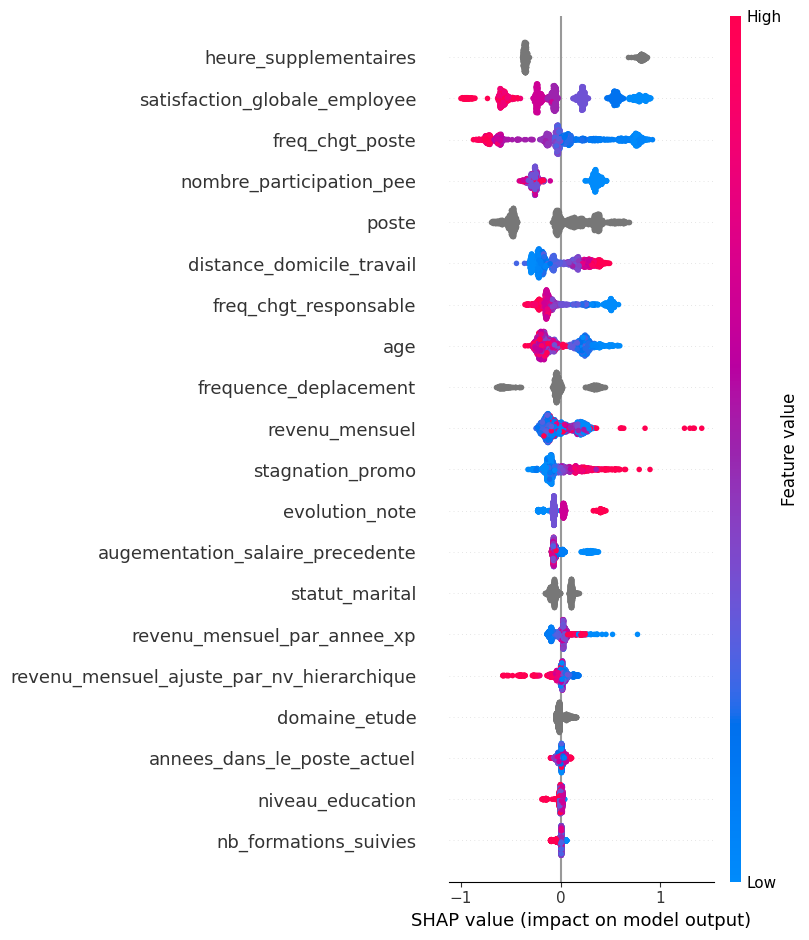

In [76]:
# Beeswarm: permet de voir importance globale + direction effet + distribution
# shap.plots.beeswarm(shap_xp)
shap.summary_plot(shap_xp,X)

Le beeswarm (summary_plot) est une méthode très utilisée qui permet une visualisation multifactorielle de l'impact des features et de leur valeur sur la target. Le graphique se lit ligne par ligne (feature par feature) et permet de visualiser:
1. l'importance globale des features en classant de haut en bas, l'importance moyenne absolue des shap values qui composent les features
2. la direction de l'effet où chaque point correspond à une observation et la tonalité de la couleur correspond à la valeur de la feature (avec la colorbar sur la droite)
3. l'impact de l'observation sur la probabilité de la classe cible (une shap value < 0 réduit la probabilité tandis qu'une shap value > 0 l'augmente). Remarque: Pour les variables catégorielles, on se retrouve avec un coloris gris.
4. Au sein d'une même feature, un alignement vertical des points signifie que plusieurs observations ont la même shap value.  
- **Importantes**:
    1. **heure_supplementaires**: (variable catégorielle) On ne peut pas distinguer ceux faisant des heures supp cependant on sait plusieurs choses: c'est la feature la plus influente, une partie des points sont à l'extrêmité droite de l'axe shap ce qui signifie qu'il y a un risque très accru de départ suivant cette feature. Cependant une partie des points se trouve sur le côté gauche, alignés verticalement mais aussi pas à son extrêmité donc possiblement l'autre valeur de la feature réduit le risque de départ. **L'hypothèse ici est que les heures supp ont tendance à augmenter la possibilité d'une démission.**
    2. **freq_chgt_poste** = On observe une répartition de la tonalité similaire à la colorbar avec le bleu a droite et le rouge a gauche ce qui signifie que les gens ayant fréquemment changé de poste ont plutôt tendance à rester (**contre-intuitif**). **Une hypothèse serait que les jeunes salariés veulent diversifier leur expérience et/ou les employés stagnant et n'ayant connu que cette entreprise veulent partir**
    3. **satisfaction_globale_eployee**: La tonalité bleu est concentrée du côté droit tandis que le rouge est du côté gauche ce qui signifie que pour une valeur elevée de satisfaction globale, la probabilité de démission diminue.
    4. **nombre_participation_pee**: On a deux blocs à peu près identiues situées aux côtés de l'axe horizontal mais on peut voir que du coté droit, seuls la tonalité bleu est présente tandis que du côté gauche, on a du violet et rouge ainsi on en déduit que la probabilité de démission est accentuée si l'employeur participe très peu voir pas au pee.
    5. poste: (variable catégorielle) On observe un bloc tout à gauche puisque une répartition continue entre 0 et 1 sur l'axe shap. **La feature est importante et il semble y avoir un facteur, peut-être sur la hierarchie du poste permettant d'amplifier ou réduire la probabilité de démission mais on ne peut pas le distinguer ici.**  
- **Intermédiaires**: 
    9. **freq_chgt_responsable**: On observe que les points bleus sont a droite et les points rouges sont a gauche de l'axe shap. Avoir un même responsable logntemps accentue donc le risque de départ.
    10. **distance_domicile_travail**: Le rouge est à droite et le bleu a gauche. Une distance elevée accroit la probabilté de démission
    11. **age**: Tonalité rouge a gauche et bleue a droite. Les personnes âgées présentent moins de risque de partir (*supporte l'hypothèse sur la frequence de changement de poste*)
    12. **revenu_mensuel**: Homogénéité de part et d'autres de l'axe avec quelques points rouge à l'extrême droite. Le risque de départ ne semble pas être corrêlé avec le salaire mensuel et **les quelques points rouges extrêmes sont minimes et peuvent traduire l'hypothèse qu'ils cumulent d'autres facteurs propices à la démission dont le salaire elevé ne permet pas de contrebalancer.**
    13. **frequence_deplacement**: (catégorielle) On a trois tas symétriques avec un offset sur la gauche. **Sachant que 3 valeurs sont possible pour cette feature, l'hypothèse ici est donc qu'une faible fréquence de déplacement permet de réduire le risque démission.**
    14. **stagnation_promo**: Rouge a droite/ bleu a gauche. Les employés qui stagnent ont une tendance accrue à partir.
    15. **evolution_note**: Rouge a droite/ bleu a gauche. Contre-intuitivement, les variations positives d'évaluation montrent un accroissement du risque de départ. **Les employés cherchent peut-être à partir en bon terme notamment en finissant toute leur tâches/ en remplissant leurs objectifs ce qui expliquerait aussi que les points rouge soient discontinues et plus à droite que le reste.**
    16. **augementaiton_salaire_precedente**: Concentrationdes points autour de 0 avec une séparation tout de même de la tonalité rouge a gauche et bleues à droite avec petite dispersion du bleu plus a droite. Les grosses augmentations réduisent un petit peu le risque de départ tandis qu'elle accroissent d'avantage le risque de départ lorsque celui-ci est faible.
    17. statut_marital: (catégorielle) Deux blocs concentrées autour de 0. On a trois modalités, suivant les autres features, **l'hypothèse est que les célibtaires auraient plus de risque de partir que les marié(e)s et séparé(e)s (age, enfants, propriétaire...)**
    18. **revenu_mensuel_par_annee_xp**: Un peu mélangé côté droit avec tout de même une prépondérance du rouge a droite et du bleu a gauche. Un coût elevé par année d'expérience entraîne une probabilité accrue de départ, **cela s'explique par le fait que la croissance du salaire décroît avec le nombre d'année d'expérience (bleu en général plus xp VS rouge en général peu xp) ce qui corrobore l'hypothèse que les jeunes ont une tendance accrue à démissioner**
    19. **revenu_mensuel_ajuste_par_nv_hierarchique**: Rouge a gauche et bleu a gauche. Un niveau elevé du ratio salaire/responsabilité réduit le risque de départ.
- **Faible à nulle**:  
    20. **domaine_etude**: (catégorielle) Concentré autour de 0. On ne peut pas en dire grand chose à part une faible influence.
    21. **annees_dans_le_poste_actuel**:Concentré autour de 0 avc symétrie du rouge de part et d'autres.
    22. **niveau_education**: On observe quelque points rouge plutôt orientés du côté gauche mais globalement les points sont autour de 0. Les personnes avec une éducation élevée ont un peu plus de chance de rester.
    23. **nb_formations_suivies**: Concentré autour de zéro avec tout de même une présence accrue côté gauche du rouge et bleu du côté droit. La plus faible influence d'entre tutes les features, l'employé à tout de même moins de chance de partir s'il a suivi plusieurs formations.



<span style='color:purple;font-weight:bold'> Feature importance locale (SHAP: waterfall plots) </span>

<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow"> IMPORTANT: Les analyses locales vont notamment employée y_pred qui se base X_test du coup il faut utiliser un shap local ou alors il y aura des incohérences</span>

In [77]:
# SHAP local
tree_xp_local = shap.TreeExplainer(best_model)
shap_xp_local = tree_xp_local(X_test) #Explanation object /

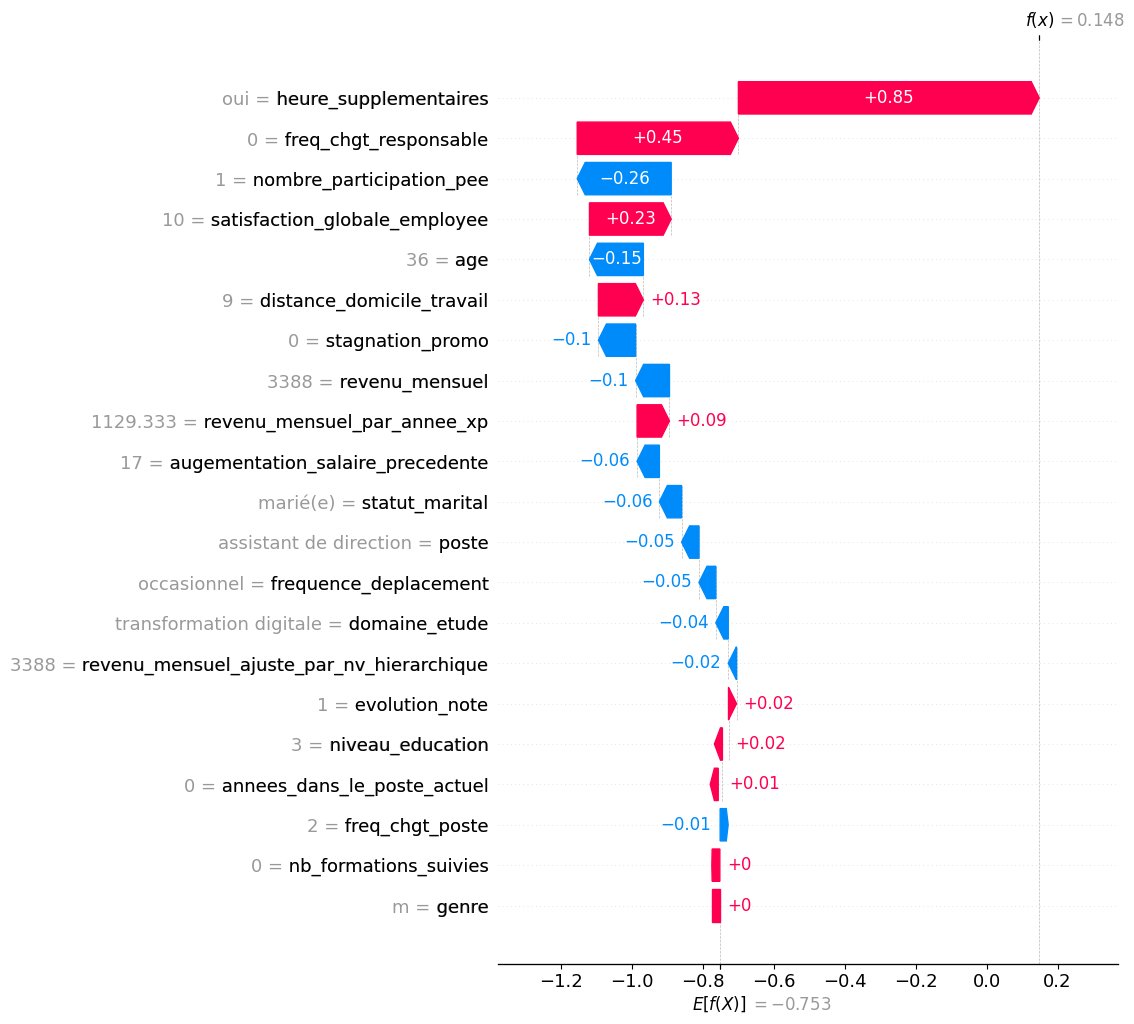

In [98]:
# Choix d'une obs
i = 4 # index de l'observation dans X

shap.plots.waterfall(
    shap_xp_local[i],
    max_display = 22
)

In [99]:
obs_i = y_test.iloc[i]
if obs_i == 1:
    print(f'L"employé est partie')
else:
    print(f'L"employé est restée')

L"employé est partie


Waterfall permet de mettre sous la forme d'un diagramme de contribution, l'influence des features sur la prédiction.  
On peut voir sur la gauche, les features et la valeur qui leur est associée à l'observation choisie tandis qu'à droite on peut voir les contributions à la prédiction sous la forme de flèche colorée avec les valeurs. Tout en bas où est notée $\text{E[f(X)]}$ correspond à la valeur de base (espérance/**prédiction moyenne du modèle**) par lequel on remonte au fur et à mesure, suivant des variables de plus en plus influente pour arriver à $\text{f(x)}$ qui est la contribution finale (**prédiction finale**).  

Beeswarm avait montrée que le top 5 des features ayat une forte influence sur la classe cible était les heures supplémentaires puis la fréquence de turnover, la satisfaction globale, le nombre de participation pee et le poste occupé.
Ce qu'on observe:
1. **heure_supplementaires = oui**: Etant une variable catégorielle et binaire, l'hypothèse était que les heures supp incitait à la démission et c'est ce qu'on observe ici avec une probabilité très accrue.
2. **freq_chgt_responsable = 0**: La personne est resté avec le même responsable tout du long ce qui se traduit par un risque accru de départ
3. **nombre_participation_pee = 1** Avec une participation, il y a déjà une réduction du risque de départ.
4. **satisfaction_globale_eployee = 10**: avec un maximum à 16 points, une moyenne et médiane à plus de 10, on observe ici que la satisfaction globale n'est pas présente et correspond à un profil démissionaire, d'où le fait que son influence soit la plus forte sur cet employé
6. **age = 36**: A 36 ans, le modèle considère que c'est un âge suffisamment avancé pour réduire le risque de départ

On retrouve les heures supp, la satisfaction globale et le pee mais le poste occupé influe peu et la fréquence de changement de poste a une influence quasi nulle sur ce profil. Les heures supplémentaires sont la raisons principale de la prédiction du modèle puis le responsable, les autres features ayant une influence amoindries voir nulle assez rapidement.

Si on regarde le score finale $\text{f(x)} = 0.148$ soit $\text{p(f(x))}=\frac{1}{1+e^{-f(x)}} \approx 0.54$ soit 54% de chance d'être démissionaire (calcul de probabilité suivant la formule des log-odds) ce qui est confirmé par son statut.

In [90]:
# # Autre moyen de représentation local / ne convient pas ici, les noms et valeurs se chevauchent
# shap.plots.force(
    
#     shap_xp_local[i],
#     matplotlib=True,
#     figsize=[20,4], #[wide,height]
# )

On a pu voir que **les heures supplémentaires** avait la plus forte influence sur l'observation cependant avec ce graphique nous nous concentrons sur un cas particulier, nous sommes alors incapable de savoir plus précisemment l'impact de la valeur de la feature sur la cible, c'est pourquoi nous utilisons alors le plot scatter qui pemet de tracer l'évolution des shapley suivant les valeurs de la feature.  

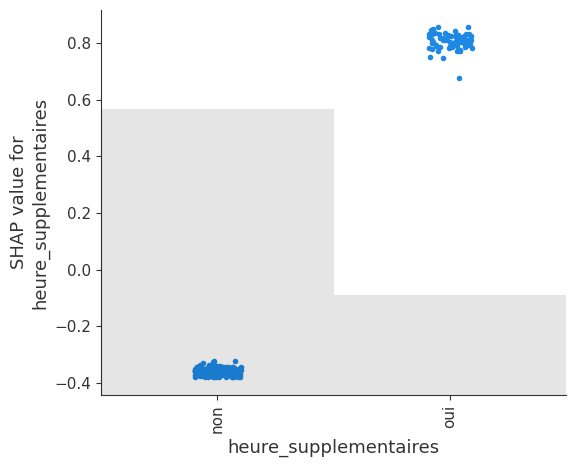

In [100]:
shap.plots.scatter(shap_xp_local[:, "heure_supplementaires"])

Comme on s'en doutait, la probabilité de départ s'accentue fortement lorsqu'il fat des heures supplémentaires. Par contre il diminue deux moins le risque s'il n'en fait pas.

Généralisons maintenant en regardant différents cas.

==================== Cas idx_tp===========================


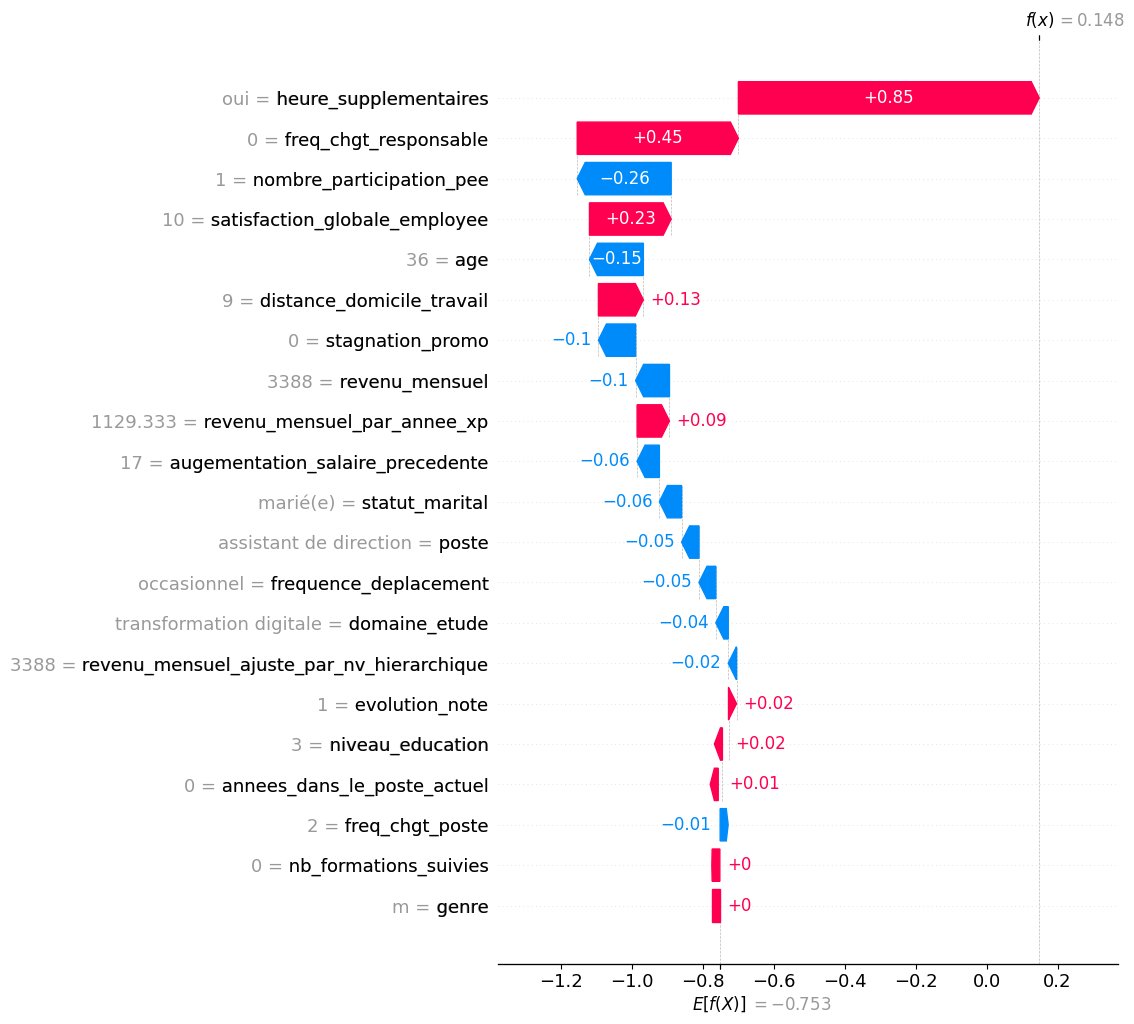

==================== Cas idx_tn===========================


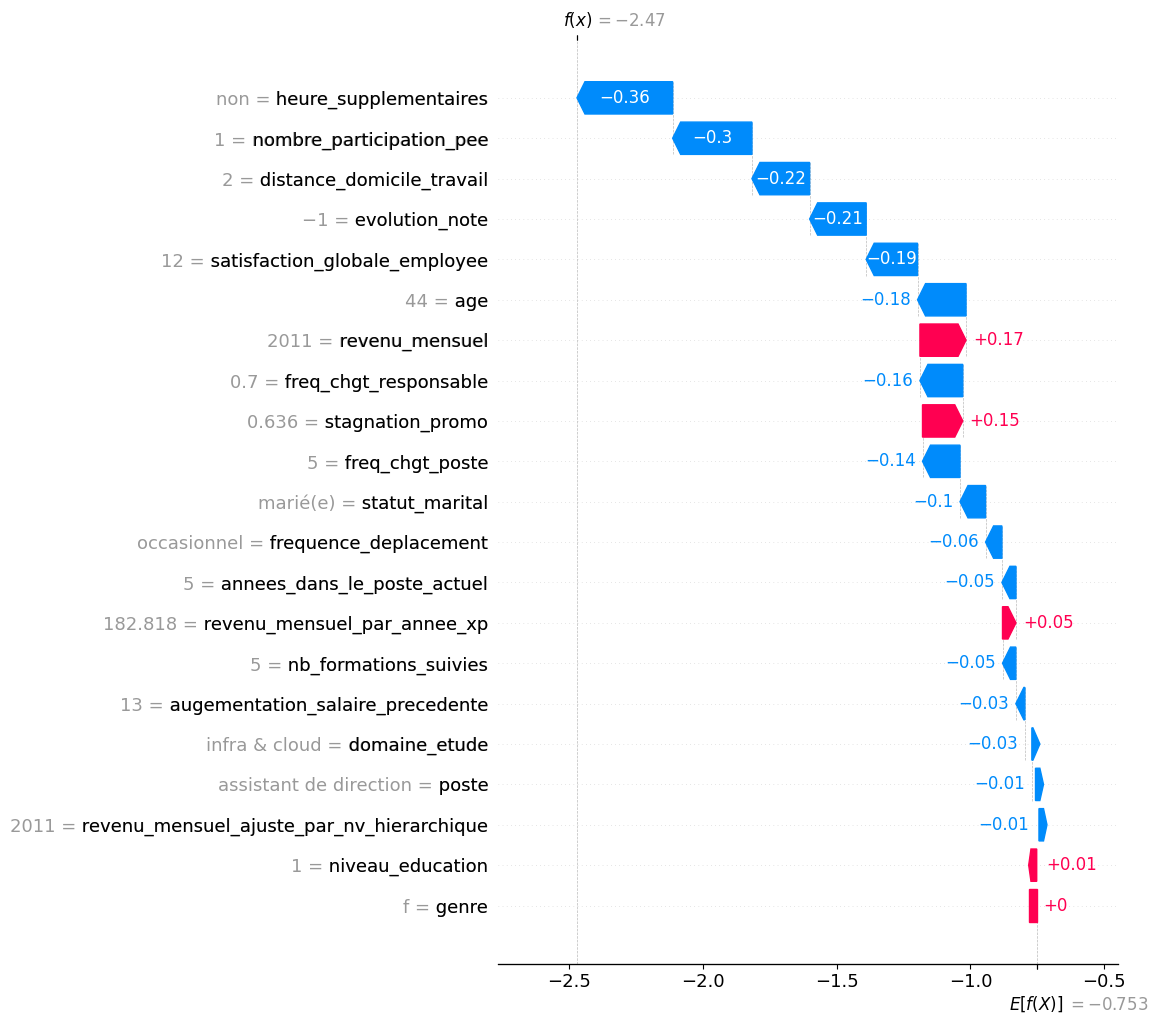

==================== Cas idx_fp===========================


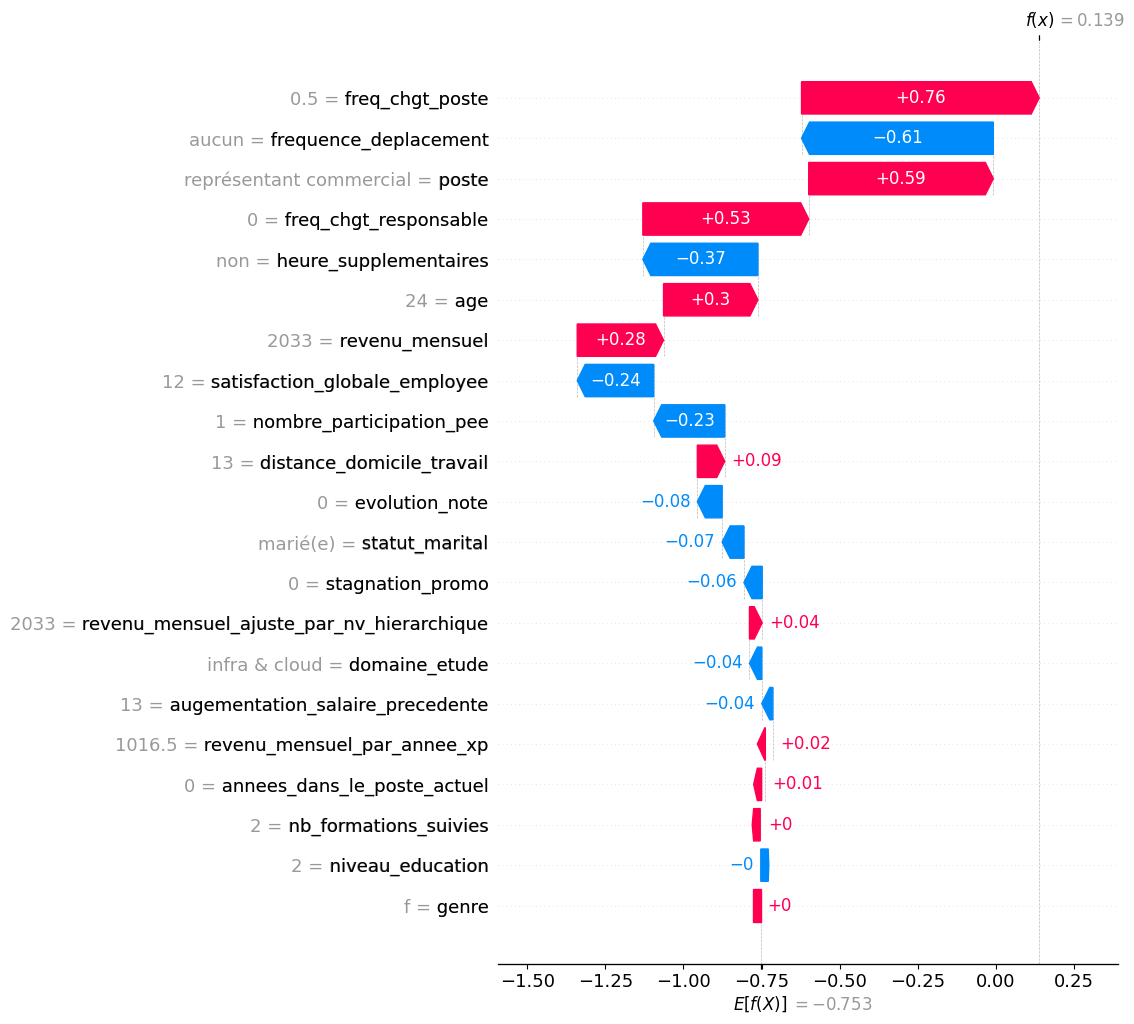

==================== Cas idx_fn===========================


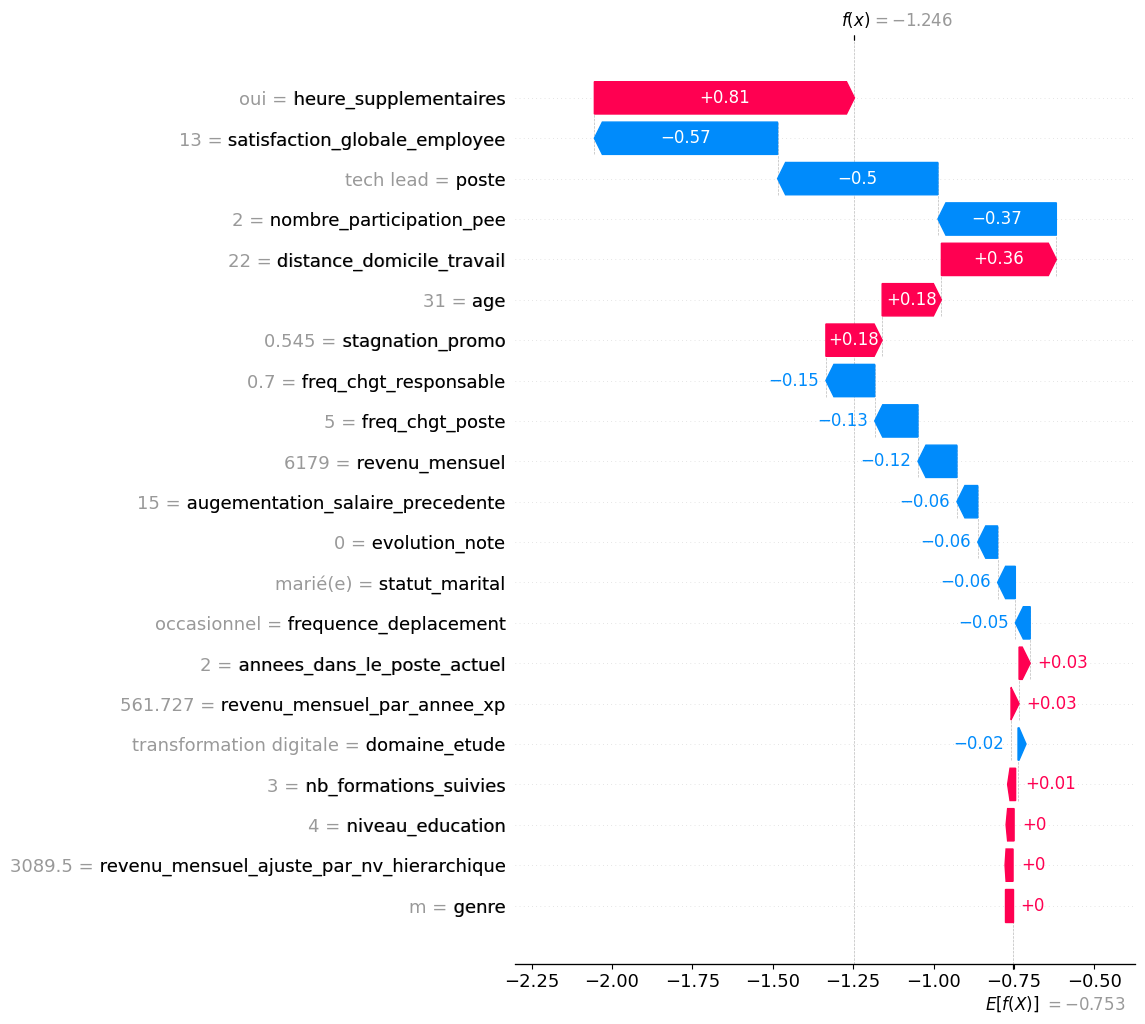

In [93]:
# Recherche des différents cas possibles afin de voir l'influence des features et comprendre le comportement du modèle
# RAPPEL:
# y_pred_proba = rdm_search.predict_proba(X_test)[:,1]
# y_pred = (y_pred_proba >= threshold_opt).astype(int)
# threshold_opt = 0.269441

# dernier crochet pour ne s'attarder qu'au premier élément / rmq: on regarde le subset qu'on avait utilisé pour éviter des confusions
idx_tp = np.where((y_test == 1) & (y_pred == 1))[0][0] # Vrai positif (démissionaire)
idx_tn = np.where((y_test == 0) & (y_pred == 0))[0][0] # Vrai négatif (en poste)
idx_fp = np.where((y_test == 0) & (y_pred == 1))[0][0] # Faux positif (confondu avec démissionaire)
idx_fn = np.where((y_test == 1) & (y_pred == 0))[0][0] # Faux négatif (confondu avec en poste)


# print(f"indice tp : {idx_tp}")
# print(f"indice tn : {idx_tn}")
# print(f"indice fp : {idx_fp}")
# print(f"indice fn : {idx_fn}")

confusion_idx_dict = {
    'idx_tp':idx_tp,
    'idx_tn':idx_tn,
    'idx_fp':idx_fp,
    'idx_fn':idx_fn,

}

# SHAP waterfall associé
for key,value in confusion_idx_dict.items():
    print(f"==================== Cas {key}===========================")
    shap.plots.waterfall(
        shap_xp_local[value],
        max_display = 22
    )

In [94]:
for value in confusion_idx_dict.values():
    obs_i = y_pred[value]
    if obs_i == 1:
        print(f'L"employé est partie')
    else:
        print(f'L"employé est restée')

L"employé est partie
L"employé est restée
L"employé est partie
L"employé est restée


In [95]:
for value in confusion_idx_dict.values():
    obs_i = y_test.iloc[value]
    if obs_i == 1:
        print(f'L"employé est partie')
    else:
        print(f'L"employé est restée')

L"employé est partie
L"employé est restée
L"employé est restée
L"employé est partie


On a pris les premieres observations de chanque catégorie (TP,TN,FP,FN). Cela va nous permettre de mieux comprendre comment le modèle se comporte et notamment quelles features ont poussé les observations vers la classe prédite.  

- **TP**: On retrouve le cas précédent.

- **TN**: On observe ici que c'est plutôt l'accumulation des features qui semble conduire la personne à rester, contrairement au cas précédent, on a pas de grands écart d'influence entre les features et le top 3 se compose des heures supplémentaires le nombre de participation aux pee et de la distance au domicile.Nous avions pu voir que les heures supp réduisant moins qu'ils n'augmente la probabilité de départ et est considéré aussi comme l'une des features les plus importance dans la feature importance globale. Cela se confirme notamment avec les deux autres features lorsqu'on regarde les scatter, le range du pee et celui de la distance au domicile sont d'environ $\pm 0.4$, ils ont donc moins d'impact (en absolu) que les heures supp bien qu'ils aient le meme impact de réduction minimal de départ. La probabilité de départ est de ($\text{p(f(x))} \approx 0.08$) donc une probabilité très faible de départ qui se confirme.

- **FP**: Cette fois-ci le top est composé de la fréquence de changement de poste, la fréuence de déplacement, le poste et la fréquence de chagement de responsable qui ont toute une influence assez importante. La personne ne se déplace pas, ne fait pas d'heures supplémentaire et est plutôt satisfait mais il a très peu changé de poste et occupe un poste qui incite au départ, de plus il n'a pas changé de responsable et il a un salaire jugé faible (tout cela peut s'expliuer par son jeune age notamment). la probabilité de son départ à été estimé à $\text{p(f(x))} \approx 0.53$ or il est resté ce qui pourrait se traduire par le fait que les profils jeunes sont plus complexes par exemple.

- **FN**: Encore une fois, les heures supplémentaires a un fort impact mais on voit un cumul de features qui réduisent fortement la probabilité de son départ avec notamment une bonne satisfaction globale, un poste intérressant et une participation aux pee qui poussent le modèle à penser que l'employé reste ce qui n'est pas le cas. Si on regarde $\text{p(f(x))} \approx 0.22$ ce qui est assez proche du seuil de validation.

On observe donc ici que l'importance globale des features ne correspond pas totalement au local, les observations sont souvent drivés par les mêmes features avec un ordre plus ou moins différent tout de même mais leur impact semblent correspondre au global. Le sens de l'impact est d'ailleurs avantagé pour les départs comme nous le souhaitions mais on peu observer une zone de floue éventuelle lorsque la probabilité n'est pas orienté vers un extrême ou l'autre (logique) 

In [202]:
### Note: Sympa mais pas vraiment utile ici
# # SHAP scatter associé à la feature la plus influente pour l'indice donnée
# for key,value in confusion_idx_dict.items():
#     print(f"==================== Cas {key}===========================")
#     # On trouve l'indice avec la shap value la plus elevée
#     shapley_max_idx = np.argmax(shap_xp[value].values)
#     # shap_xp[value].data[shapley_max_idx] renvoi la valeur de la feature ayant le shap value max combinée à iloc.values 
#     # on trouve alors l'indice de la colonne concernée (True) puis en encapsulant dans columns et [0] on trouve le nom de la feature
#     ref = X.columns[(X.iloc[value,:] == shap_xp[value].data[shapley_max_idx]).values][0]
#     # print(value,ref)
#     shap.plots.scatter(shap_xp[:, ref])

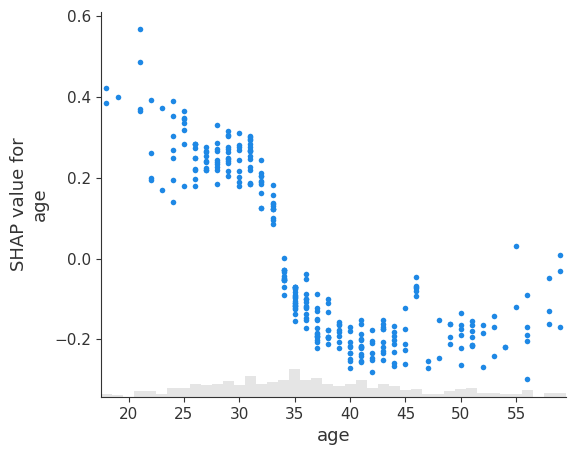

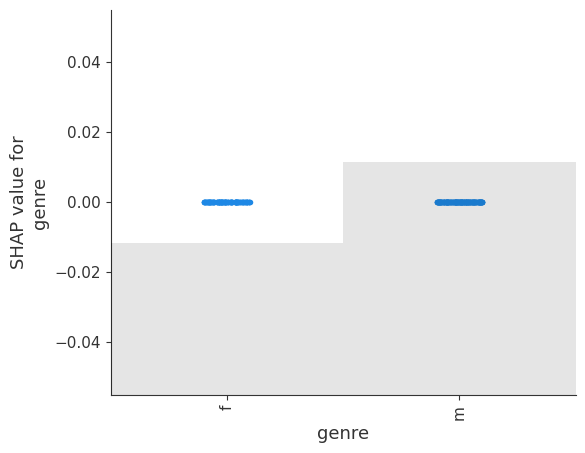

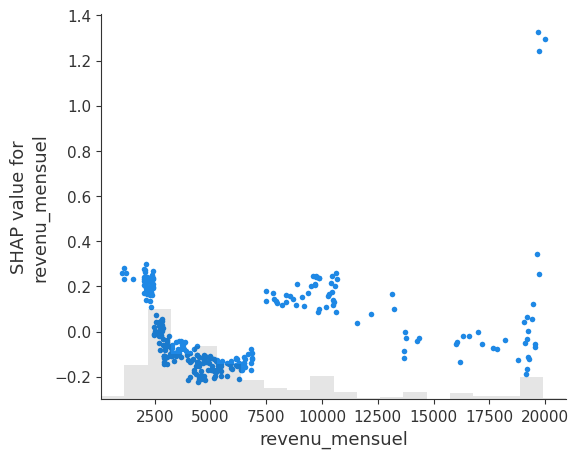

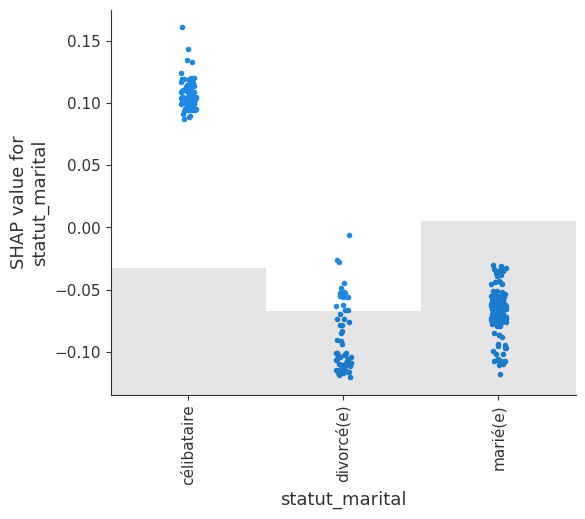

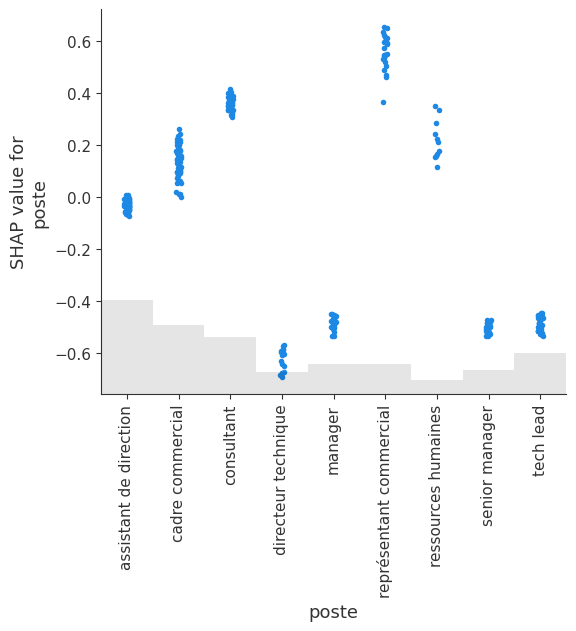

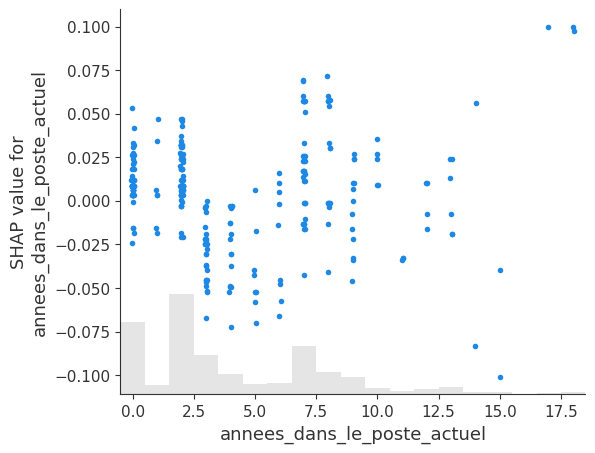

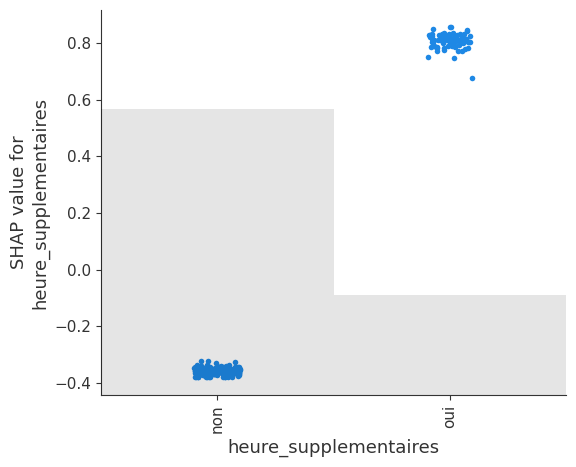

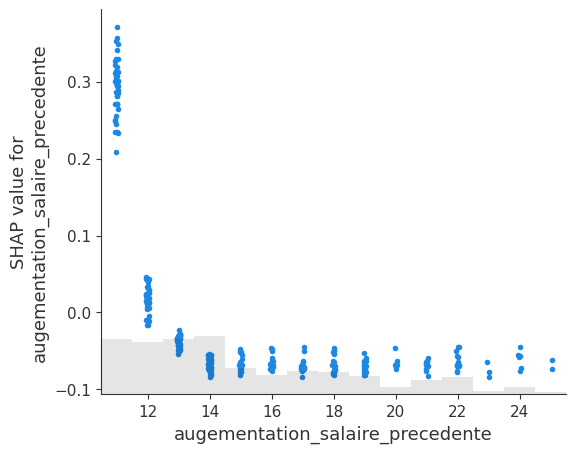

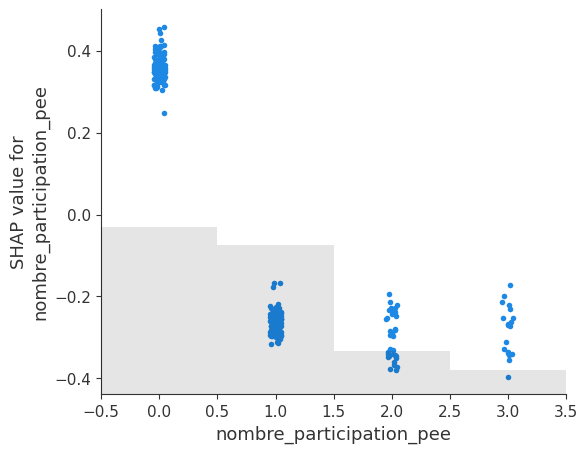

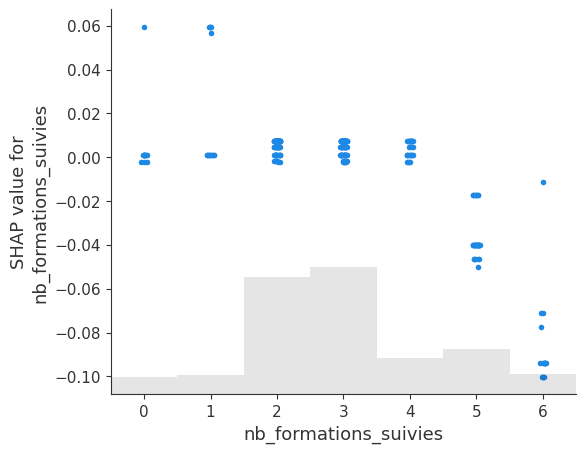

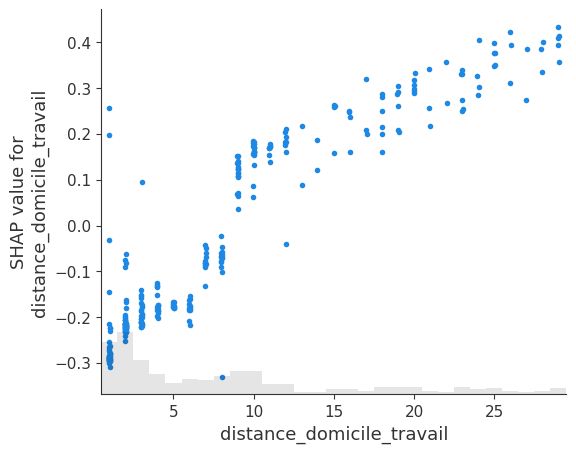

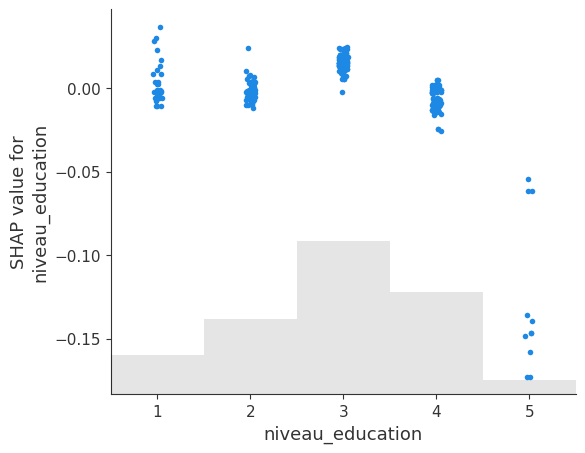

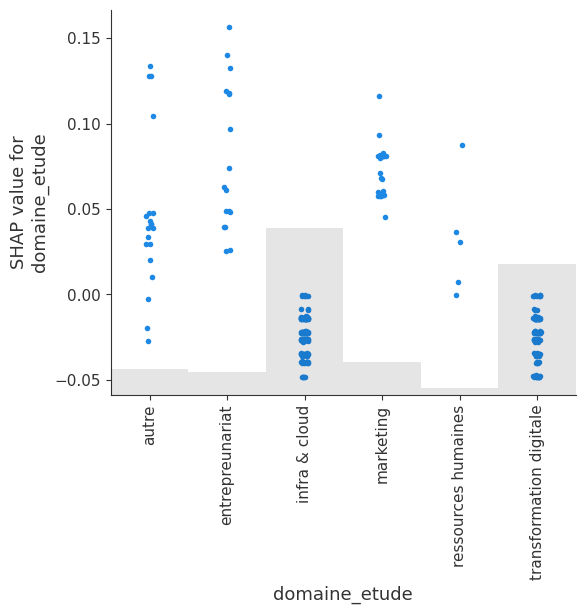

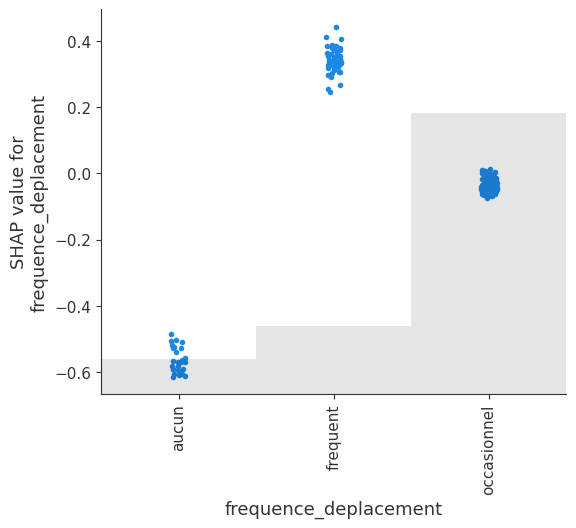

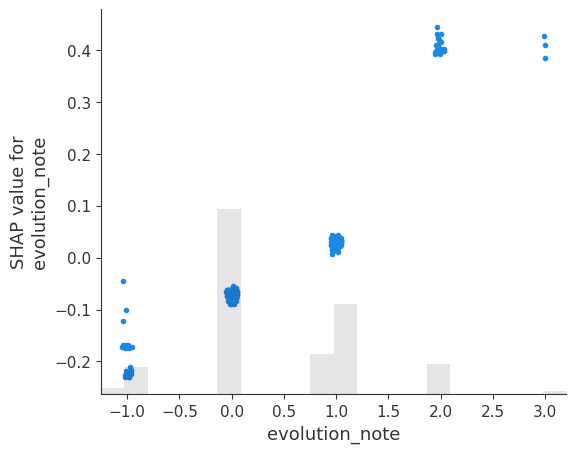

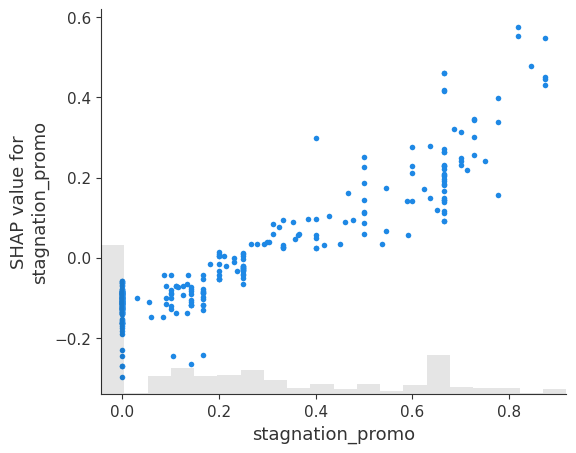

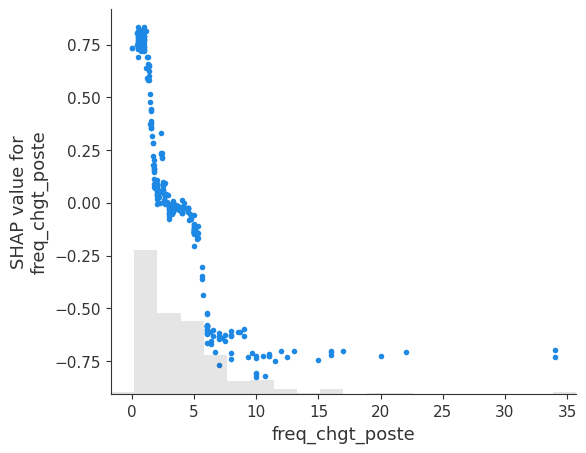

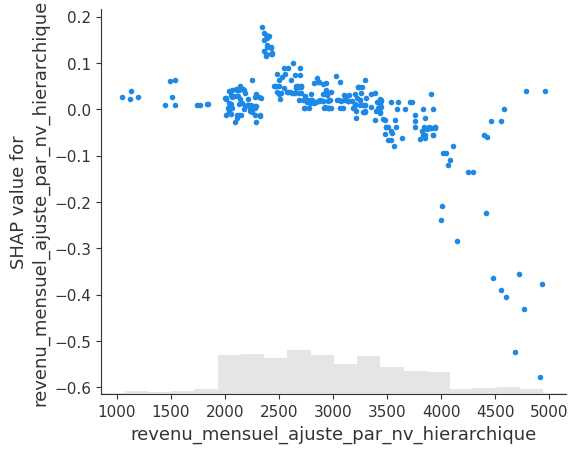

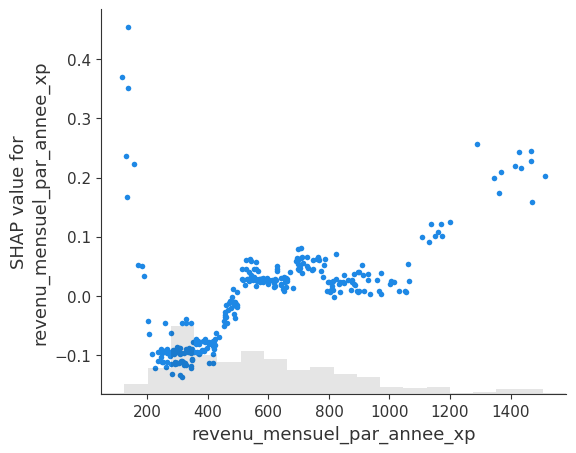

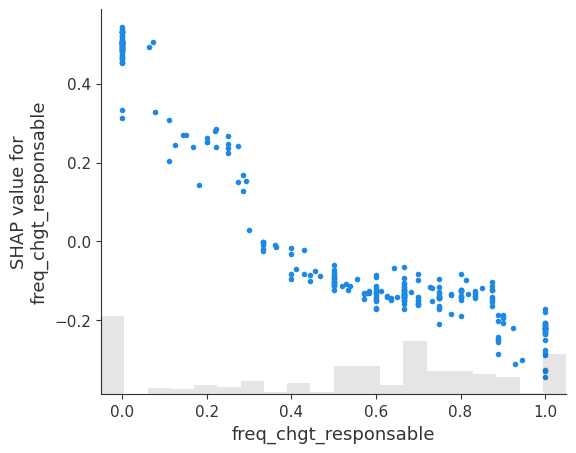

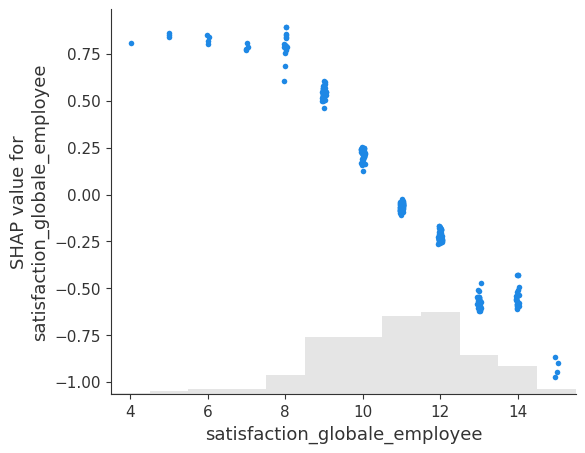

In [96]:
# SHAP scatter de chaque feature
for feat in X_test.columns:
    shap.plots.scatter(shap_xp_local[:, feat])

<span style='color:blue;font-size:1.5em;font-weight:bold;background-color:yellow'> Conclusion </span>

pb: Causes racines des démissions

Le problème principal concerne conditions/investissement de travail avec les heures supplémentaires et la satisfaction globale. Elles se combinent bien avec le fait que l'employé reste avec le même responsable (mauvais management?), le nombre de pee ou le poste occupé.  
Lorsque l'employé a de l'expérience dans le monde professionnel au sens ou il a pu avoir plusieurs expériences différentes, celà réduit le risque de départ probablement car cette feature traduit indirectement une multitude de facteur. En effet si on a de l'expérience on est mieux rémunéré, on a plus expérimenté, on est plus âgé etc... et donc il semblerait que les profils peu diversifés soient plus enclin a partir (pour découvrir le monde?).
Etonnament, le salaire reste un facteur mais ne joue pas un rôle prépondérant. 

Evidemment, beaucoup de features ont une influence non négligeable sur le choix de l'employé mais on peut dire que la root cause des démission concerne les conditions de travail.

<span style='color:blue;font-size:1.5em;font-weight:bold;background-color:yellow'> Sauvegarder et recharger le modèle </span>

Avec CatBoostClassifier on peut sauvegarder le modèle sous le format .cbm.  
- conserve l'architecture
- conserve les poids
- conserve les features catégorielles
- optimisé pour catboos
- standard recommandé

In [180]:
if save_model: 
    best_model.save_model(save_path_model.joinpath(f'{name_model}.cbm'))

In [191]:
if save_pool:
    pools = {
        "global_pool":Pool(X,y,cat_features=cat_list),
        "train_pool":Pool(X_train,y_train,cat_features=cat_list),
        "test_pool":Pool(X_test,y_test,cat_features=cat_list),
    }
    
    for key,value in pools.items():
        try:
            value.save(save_path_pool.joinpath(f"{key}.pool"))
        except:
            print(f"la pool {key} n'est pas quantized ==> pas de sauvegarde") 
            continue
            

la pool global_pool n'est pas quantized ==> pas de sauvegarde
la pool train_pool n'est pas quantized ==> pas de sauvegarde
la pool test_pool n'est pas quantized ==> pas de sauvegarde


In [195]:
# Pour conserver les params utilisées pour le RandomizedSearchCV
if save_hyperparams:
    hyperparams = rdm_search.get_params()
    with open(save_path_hyperparams.joinpath("params_rdm_search.pkl"),"wb") as f:
        pickle.dump(hyperparams,f)

In [196]:
# Pour conserver les metriques et seuils
if save_metrics_thresh:
    results.to_csv(save_path_metrics.joinpath("metrics.csv"),index=False)
    with open(save_path_threshold_opt.joinpath("thresh_opt.pkl"),"wb") as g:
        pickle.dump(threshold_opt,g)

Pour recharger le modèle

In [25]:
if load_model:
    model_saved = CatBoostClassifier()
    model_saved.load_model(f"../datas/results/model/{name_model}.cbm")
    best_model = model_saved